### <font color='blue'>チャンカの開発と評価</font>

今まで、どのようにチャンカを評価すれば良いか説明してきていない。<br>
評価には、適切に注釈のつけられたコーパスが必要になる。<br>
そこでIBOフォーマットをNLTKの木構造に変換する仕組みと、チャンキングされたコーパスを利用して<br>
それを大規模に行うにはどのようにしたら良いかをみる。<br>

まずは、チャンカのあるコーパスにおける相対的な正解率を算出する方法。<br>
続いてNPチャンクの検索に用いるさらにいくつかのデータ駆動型の手法。<br>
その間にチャンカの適用範囲を広げる。<br>

### <font color='blue'>IOB フォーマットと CoNLL-2000 チャンキングコーパスの読み込み</font>

変換関数chunk.conllstr2tree()には、以下のIBOフォーマットから<br>
木構造を構築することができる。<br>

In [2]:
text = '''
he PRP B-NP
accepted VBD B-VP
the DT B-NP
position NN I-NP
of IN B-PP
vice NN B-NP
chairman NN I-NP
of IN B-PP
Carlyle NNP B-NP
Group NNP I-NP
, , O
a DT B-NP
merchant NN I-NP
banking NN I-NP
concern NN I-NP
. . O
'''

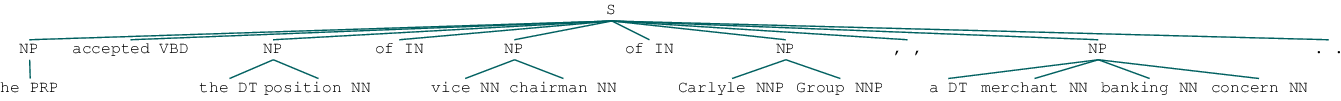

In [3]:
import nltk

# IOBフォーマットで読み込んだテキストから、NPチャンクのみを取り出して木構造を作成
nltk.chunk.conllstr2tree(text, chunk_types=['NP'])

CoNLL-2000チャンキングコーパスは、ウォールストリート・ジャーナルのテキストの27万個の単語を含んでいる。<br>
これを訓練とテストの２つに分け、IBOフォーマットで品詞タグとチャンクタグをつける。<br>

In [4]:
# ウォールストリート・ジャーナルのコーパスのimport
from nltk.corpus import conll2000

In [5]:
# コーパスの訓練データの100番目の文を表示
print(conll2000.chunked_sents('train.txt')[99])

(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


上記からチャンキングコーパスには<br>
NPチャンク、VPチャンク、PPチャンクの３つのチャンクタイプを含んでいる。<br>

In [6]:
# 表示するチャンクタイプの指定
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


### <font color='blue'>簡単な評価とベースライン</font>

チャンキングされたコーパスを読み込んで、チャンカを評価する。<br>

まずは、全くチャンクを生成しない非常に単純なチャンク構文解析器cpをベースラインとして定める。<br>

In [7]:
# コーパスのimport
from nltk.corpus import conll2000

In [8]:
# チャンカの作成
cp = nltk.RegexpParser("")

In [9]:
# テストデータとして、NPチャンクのみの抜き出し
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

In [10]:
type(test_sents[0])

nltk.tree.Tree

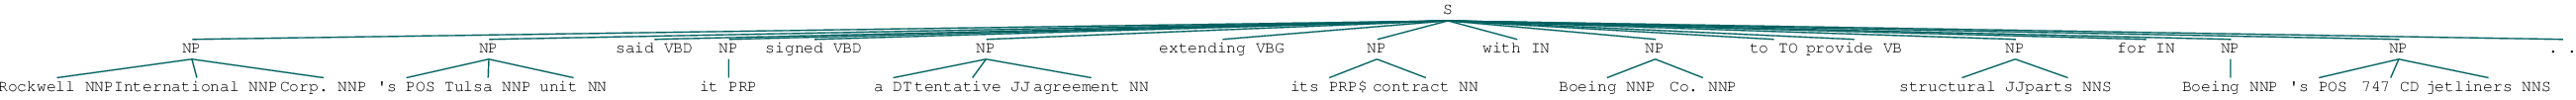

In [11]:
# 表示
test_sents[0]

In [12]:
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


上記のIOBタグの正解率の値が意味するのは、1/3以上の単語にOタグが付与されていること。<br>
つまりNPチャンクではないということ<br>
ただし、このタガーはチャンクを全く見つけていないということに注意。<br>

名詞タグを特徴的に表す文字で始まるタグを発見する、単純な正規表現チャンカを使う。<br>

In [13]:
# チャンキング文法
# CD、DT、JJを特徴的に表す文字で始まるタグを発見する
grammar = r"NP: {<[CDJNP].*>+}"

In [14]:
# チャンキング文法の構築
cp = nltk.RegexpParser(grammar)

In [15]:
print(cp.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


結果から、上記のチャンカでも比較的ちゃんとした結果を示す。<br>
しかし、よりデータ駆動型のアプローチを追加することで、この結果をさらに改良できる。<br>

訓練コーパスを利用して、(I、B、Oのいずれか)を探す。<br>
別の言い方をすると、ユニグラムタガーを利用して、チャンカを構築する。<br>
ただし、ユニグラムタガーは、品詞タグを与えて正しいチャンクタグを決定する。<br>

### <font color='blue'>ユニグラムタガーを利用したチャンカ</font>

UnigramTaggerでは、タガーの初期化の際に、タグ付けされた文章を引数に与える訓練を行う。<br>
訓練では最も多く使われているタグを、タガー内に保持されているディクショナリに保持。<br>

In [55]:
# ユニグラムタガーを用いた名詞句チャンキング
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents] # 木構造からIBOフォーマットに変換し、品詞とIBOを抜き出し学習データとして用いる
        
        self.tagger = nltk.UnigramTagger(train_data) # 学習データからユニグラムタガーチャンカを作成
    
    # テストデータでの評価時のみに読みこまれる
    def parse(self, sentence): # タグ付けされた文章を受け取る
        # print("parse function is called")
        # nltk.ChunkParserlでsentenceに変更か
        # print("sentence : " + str(sentence))
        # print("")
        pos_tags = [pos for (word,pos) in sentence] # 品詞タグの抽出
        
        tagged_pos_tags = self.tagger.tag(pos_tags) # 学習済みのタガーを利用してIBOチャンクタグの付与
        
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags] # チャンクタグの抜き出し
        # print("chunktags : " + str(chunktags))
        # print("")
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)] # conlltagsが得られる
        # print("conlltags : " + str(conlltags))
        # print("")
        
        return nltk.chunk.conlltags2tree(conlltags) # IBOフォーマットを木構造に変換して返す

In [56]:
# テスト用にIBOフォーマットからNPチャンクのみの抜き出し
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

In [57]:
type(test_sents)

nltk.collections.LazyMap

In [58]:
type(test_sents[0])

nltk.tree.Tree

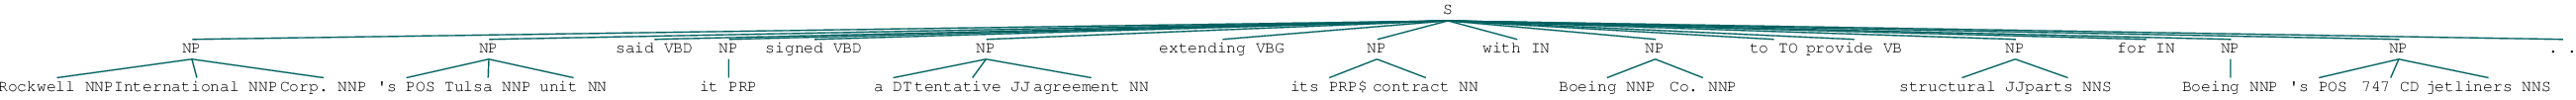

In [59]:
# テスト文章から最初の文章のみの抜き出し
test_sents[0]

In [60]:
# 訓練用に文章からIBOフォーマットのNPチャンクのみの抜き出し
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])

In [61]:
type(train_sents)

nltk.collections.LazyMap

In [62]:
type(train_sents[0])

nltk.tree.Tree

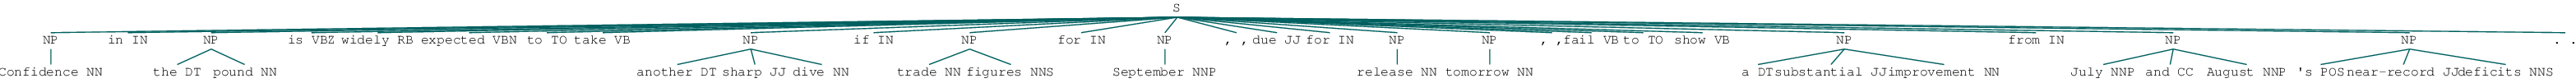

In [63]:
train_sents[0]

In [64]:
# チャンカの訓練
unigram_chunker = UnigramChunker(train_sents)

In [65]:
# テストデータを用いて評価
print(unigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


上記から、このチャンカはなかなか良い性能を出している。<br>

以下にどのようなことを学習しているのかみる。<br>

In [27]:
postags = sorted(set(pos for sent in train_sents for (word, pos) in sent.leaves()))

In [28]:
print(unigram_chunker.tagger.tag(postags))

[('#', 'B-NP'), ('$', 'B-NP'), ("''", 'O'), ('(', 'O'), (')', 'O'), (',', 'O'), ('.', 'O'), (':', 'O'), ('CC', 'O'), ('CD', 'I-NP'), ('DT', 'B-NP'), ('EX', 'B-NP'), ('FW', 'I-NP'), ('IN', 'O'), ('JJ', 'I-NP'), ('JJR', 'B-NP'), ('JJS', 'I-NP'), ('MD', 'O'), ('NN', 'I-NP'), ('NNP', 'I-NP'), ('NNPS', 'I-NP'), ('NNS', 'I-NP'), ('PDT', 'B-NP'), ('POS', 'B-NP'), ('PRP', 'B-NP'), ('PRP$', 'B-NP'), ('RB', 'O'), ('RBR', 'O'), ('RBS', 'B-NP'), ('RP', 'O'), ('SYM', 'O'), ('TO', 'O'), ('UH', 'O'), ('VB', 'O'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'B-NP'), ('WP', 'B-NP'), ('WP$', 'B-NP'), ('WRB', 'O'), ('``', 'O')]


上記からほとんどの句読点記号がNPチャンクの外に位置していることがわかる。<br>
#と$については例外で、これらは通貨を表すために使われている。<br>

限定詞(DT)や所有格NPチャンクに含まれれる品詞はほとんど名詞(NN、NNP、NNPS、NN)であるが<br>
限定詞(DT)や所有格(PRP$ と WP$)でNP チャンクが始まるケースも発見できる。

### <font color='blue'>ユニグラムタガーを利用したチャンカについて詳しくみる</font>

UnigramTaggerでは、タガーの初期化の際に、タグ付けされた文章を引数に与える訓練を行う。<br>
訓練では最も多く使われているタグを、タガー内に保持されているディクショナリに保持。<br>

In [66]:
# ユニグラムタガーを用いた名詞句チャンキング
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents] # 木構造からIBOフォーマットに変換し、品詞とIBOを学習データとして抜き出し
        
        self.tagger = nltk.UnigramTagger(train_data) # タガーに結果を格納
        
    def parse(self, sentence): # タグ付けされた文章を受け取る
        
        pos_tags = [pos for (word,pos) in sentence] # 品詞タグの抽出
        # print('pos_tag')
        tagged_pos_tags = self.tagger.tag(pos_tags) # タガーを利用してIOBチャンクタグの付与
        
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags] # チャンクタグの抜き出し
        
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)] # conlltagsが得られる
        
        return nltk.chunk.conlltags2tree(conlltags) # IBOフォーマットを木構造に変換して返す

In [67]:
# 訓練用に文章からNPチャンクのみの抜き出し
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])

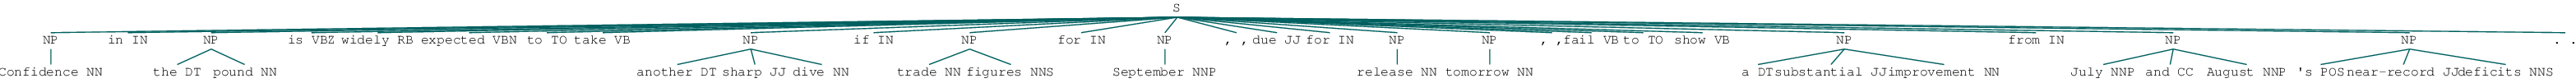

In [68]:
# 木構造になっている
train_sents[0]

In [69]:
# NPチャンクから最初の文章の抜き出し
temp_sent = train_sents[:2]

In [70]:
#  どのようなタイプか
type(temp_sent)

nltk.collections.LazyMap

In [71]:
# 品詞とIOBチャンクの抜き出し
pos_iob =  [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in temp_sent]

In [73]:
# 最初の文章の品詞とIOBの表示
pos_iob[0]

[('NN', 'B-NP'),
 ('IN', 'O'),
 ('DT', 'B-NP'),
 ('NN', 'I-NP'),
 ('VBZ', 'O'),
 ('RB', 'O'),
 ('VBN', 'O'),
 ('TO', 'O'),
 ('VB', 'O'),
 ('DT', 'B-NP'),
 ('JJ', 'I-NP'),
 ('NN', 'I-NP'),
 ('IN', 'O'),
 ('NN', 'B-NP'),
 ('NNS', 'I-NP'),
 ('IN', 'O'),
 ('NNP', 'B-NP'),
 (',', 'O'),
 ('JJ', 'O'),
 ('IN', 'O'),
 ('NN', 'B-NP'),
 ('NN', 'B-NP'),
 (',', 'O'),
 ('VB', 'O'),
 ('TO', 'O'),
 ('VB', 'O'),
 ('DT', 'B-NP'),
 ('JJ', 'I-NP'),
 ('NN', 'I-NP'),
 ('IN', 'O'),
 ('NNP', 'B-NP'),
 ('CC', 'I-NP'),
 ('NNP', 'I-NP'),
 ('POS', 'B-NP'),
 ('JJ', 'I-NP'),
 ('NNS', 'I-NP'),
 ('.', 'O')]

In [74]:
# 単語と品詞、IOBの抜き出し
word_pos_iob = [[(w,t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in temp_sent]

In [75]:
# 最初の文章の単語と品詞、IOBの表示
word_pos_iob[0]

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'O'),
 ('widely', 'RB', 'O'),
 ('expected', 'VBN', 'O'),
 ('to', 'TO', 'O'),
 ('take', 'VB', 'O'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'O'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'O'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'O'),
 ('for', 'IN', 'O'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'O'),
 ('to', 'TO', 'O'),
 ('show', 'VB', 'O'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'O'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

In [76]:
# チャンカの作成
unigram_chunker = UnigramChunker(temp_sent)

UnigramChunkerクラスに関しては、parse関数がないと、テストデータを用いて評価をすることができないということに注意。<br>

In [79]:
# テストデータ
test_sents[:2]

[Tree('S', [Tree('NP', [('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP')]), Tree('NP', [("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN')]), ('said', 'VBD'), Tree('NP', [('it', 'PRP')]), ('signed', 'VBD'), Tree('NP', [('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN')]), ('extending', 'VBG'), Tree('NP', [('its', 'PRP$'), ('contract', 'NN')]), ('with', 'IN'), Tree('NP', [('Boeing', 'NNP'), ('Co.', 'NNP')]), ('to', 'TO'), ('provide', 'VB'), Tree('NP', [('structural', 'JJ'), ('parts', 'NNS')]), ('for', 'IN'), Tree('NP', [('Boeing', 'NNP')]), Tree('NP', [("'s", 'POS'), ('747', 'CD'), ('jetliners', 'NNS')]), ('.', '.')]), Tree('S', [Tree('NP', [('Rockwell', 'NNP')]), ('said', 'VBD'), Tree('NP', [('the', 'DT'), ('agreement', 'NN')]), ('calls', 'VBZ'), ('for', 'IN'), Tree('NP', [('it', 'PRP')]), ('to', 'TO'), ('supply', 'VB'), Tree('NP', [('200', 'CD'), ('additional', 'JJ'), ('so-called', 'JJ'), ('shipsets', 'NNS')]), ('for', 'IN'), Tree('NP', [('the', 'DT'), ('planes', 'NNS')

In [40]:
# テストデータのタイプ
type(test_sents)

nltk.collections.LazyMap

In [41]:
# テストデータの長さ
len(test_sents)

2012

In [42]:
# 最初の文の取り出し
test_sents_temp = test_sents[0]

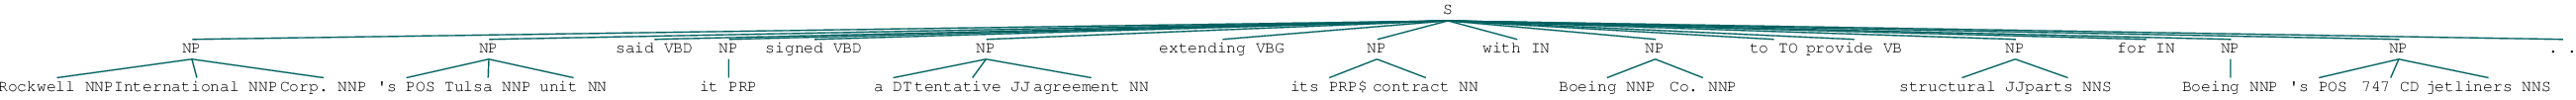

In [43]:
# 最初の文を表示
test_sents_temp

In [44]:
# 最初のデータのタイプ
type(test_sents_temp)

nltk.tree.Tree

In [45]:
list(test_sents_temp)

[Tree('NP', [('Rockwell', 'NNP'), ('International', 'NNP'), ('Corp.', 'NNP')]),
 Tree('NP', [("'s", 'POS'), ('Tulsa', 'NNP'), ('unit', 'NN')]),
 ('said', 'VBD'),
 Tree('NP', [('it', 'PRP')]),
 ('signed', 'VBD'),
 Tree('NP', [('a', 'DT'), ('tentative', 'JJ'), ('agreement', 'NN')]),
 ('extending', 'VBG'),
 Tree('NP', [('its', 'PRP$'), ('contract', 'NN')]),
 ('with', 'IN'),
 Tree('NP', [('Boeing', 'NNP'), ('Co.', 'NNP')]),
 ('to', 'TO'),
 ('provide', 'VB'),
 Tree('NP', [('structural', 'JJ'), ('parts', 'NNS')]),
 ('for', 'IN'),
 Tree('NP', [('Boeing', 'NNP')]),
 Tree('NP', [("'s", 'POS'), ('747', 'CD'), ('jetliners', 'NNS')]),
 ('.', '.')]

### <font color='blue'>バイグラムタガーを利用したチャンカ</font>

In [80]:
# ユニグラムタガーを用いた名詞句チャンキング
class BigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents] # 木構造からIBOフォーマットに変換し、品詞とIBOを抜き出し学習データとして用いる
        
        self.tagger = nltk.BigramTagger(train_data) # 学習データからユニグラムタガーチャンカを作成
    
    # テストデータを評価する時のみ呼び出される
    def parse(self, sentence): # タグ付けされた文章を受け取る
        # print("parse function is called")
        # nltk.ChunkParserlでsentenceに変更か
        # print("sentence : " + str(sentence))
        # print("")
        pos_tags = [pos for (word,pos) in sentence] # 品詞タグの抽出
        
        tagged_pos_tags = self.tagger.tag(pos_tags) # 学習済みのタガーを利用してIBOチャンクタグの付与
        
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags] # チャンクタグの抜き出し
        # print("chunktags : " + str(chunktags))
        # print("")
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)] # conlltagsが得られる
        # print("conlltags : " + str(conlltags))
        # print("")
        
        return nltk.chunk.conlltags2tree(conlltags) # IBOフォーマットを木構造に変換して返す

In [81]:
# 訓練用に文章から木構造のNPチャンクのみの抜き出し
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])

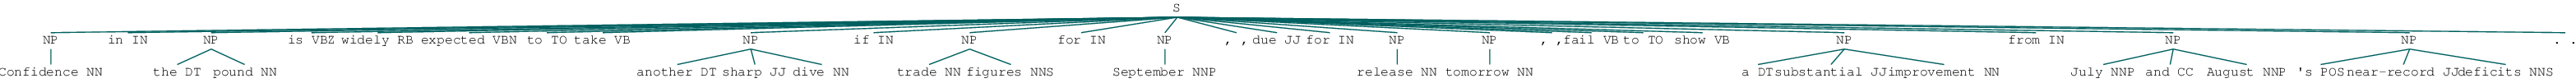

In [82]:
train_sents[0]

In [83]:
# テスト用に木構造のNPチャンクのみの抜き出し
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

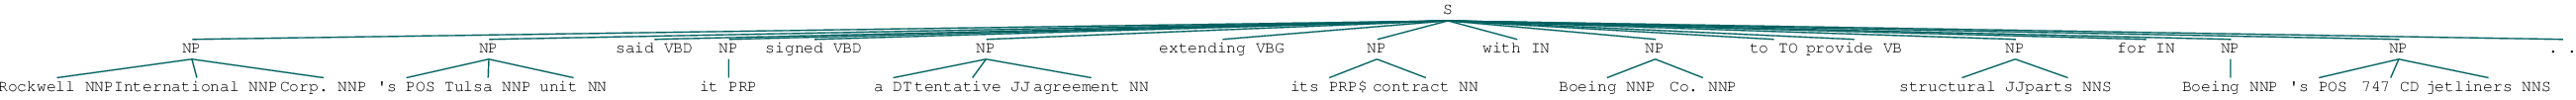

In [84]:
test_sents[0]

In [85]:
# チャンカの作成
bigram_chunker = BigramChunker(train_sents)

In [86]:
print(bigram_chunker.evaluate(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


UnigramTaggerよりも若干精度が向上している。<br>